In [1]:
import os
import pandas as pd
import mlflow
import mlflow.tensorflow
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
sample_csv_path = "/Users/maurice/Documents/certification/dermdetect/csv/sample_dataset.csv"
sampled_image_dir = "/Users/maurice/Documents/data_nogit/Dermdetect/SAMPLE_20"

In [3]:
df_sample = pd.read_csv(sample_csv_path)
df_sample

,image_id,target
0,isic_0014666_1.jpg,malignant
1,isic_4974820_0.jpg,benign
2,isic_0071045_4.jpg,malignant
3,isic_5189439_3.jpg,malignant
4,isic_0817140_0.jpg,benign
...,...,...
14515,isic_0033552_0.jpg,benign
14516,isic_7490806_0.jpg,malignant
14517,isic_7072802_0.jpg,benign
14518,isic_0025505_0.jpg,benign


In [4]:
img_generator = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.3
)

In [5]:
# Générateur pour l'ensemble d'entraînement
train_generator = img_generator.flow_from_dataframe(
    dataframe=df_sample,
    directory=sampled_image_dir,
    x_col="image_id",
    y_col="target",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    subset="training",
    seed=42
)

# Générateur pour l'ensemble de validation
val_generator = img_generator.flow_from_dataframe(
    dataframe=df_sample,
    directory=sampled_image_dir,
    x_col="image_id",
    y_col="target",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    subset="validation",
    seed=42
)

Found 10164 validated image filenames belonging to 2 classes.
Found 4356 validated image filenames belonging to 2 classes.


In [6]:
base_model  = ResNet50(
                        weights='imagenet',
                        include_top=False,
                        input_shape=(128, 128, 3)
                        )

In [7]:
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-10:]:
    layer.trainable = True

In [8]:
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',  
              metrics=['accuracy', 
                       Precision(name="precision"), 
                       Recall(name="recall"), 
                       tf.keras.metrics.AUC(name="auc")]
              )

In [ ]:
model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    verbose=1
    )

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


In [11]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Obtenir les vraies étiquettes
y_true = val_generator.classes  

# Faire des prédictions
y_pred_probs = model.predict(val_generator)  # Probabilités prédites

# Convertir les probabilités en classes
y_pred = np.argmax(y_pred_probs, axis=1)  # Pour un modèle avec softmax

# Afficher les scores globaux
print("📊 Scores de classification sur l'ensemble de validation :")
print(classification_report(y_true, y_pred, target_names=["Bénin", "Malin"]))

# Calculer l'AUC manuellement
auc_score = roc_auc_score(y_true, y_pred_probs[:, 1])  # Prend la colonne associée à "Malin"
print(f"AUC Score: {auc_score:.4f}")


137/137 ━━━━━━━━━━━━━━━━━━━━ 26s 185ms/step
📊 Scores de classification sur l'ensemble de validation :
              precision    recall  f1-score   support

       Bénin       0.50      1.00      0.67      2175
       Malin       0.00      0.00      0.00      2181

    accuracy                           0.50      4356
   macro avg       0.25      0.50      0.33      4356
weighted avg       0.25      0.50      0.33      4356

AUC Score: 0.5000


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


137/137 ━━━━━━━━━━━━━━━━━━━━ 25s 180ms/step


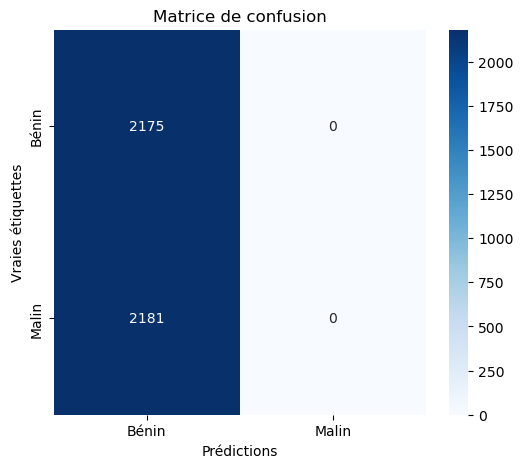

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtenir les vraies étiquettes
y_true = val_generator.classes  # Étiquettes réelles des images

# Faire des prédictions
y_pred_probs = model.predict(val_generator)  # Probabilités prédites

# Convertir les probabilités en classes
y_pred = np.argmax(y_pred_probs, axis=1)  # Indice de la classe avec la plus grande probabilité

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Affichage avec Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bénin", "Malin"], yticklabels=["Bénin", "Malin"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de confusion")
plt.show()
